# **INSTALLATION**

In [1]:
#!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#!pip install tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 578.0 MB 15 kB/s 
     |████████████████████████████████| 5.9 MB 32.9 MB/s 
     |████████████████████████████████| 438 kB 51.7 MB/s 
     |████████████████████████████████| 1.7 MB 65.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5

In [5]:
pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **DRIVE MOUNTING**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **IMPORTS**

In [21]:
import numpy as np
import random
import sys
import io
import glob
import IPython
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os
from pydub import AudioSegment

In [22]:
# Calculate and plot spectrogram for a wav audio file
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

# Load a wav file
def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data

# Used to standardize volume of audio clip
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

# Load raw audio files for speech synthesis
def load_raw_audio(path):
    activates = []
    backgrounds = []
    negatives = []
    for filename in os.listdir(path + "activates"):
        if filename.endswith("wav"):
            activate = AudioSegment.from_wav(path + "activates/" + filename)
            activates.append(activate)
    for filename in os.listdir(path + "backgrounds"):
        if filename.endswith("wav"):
            background = AudioSegment.from_wav(path + "backgrounds/" + filename)
            backgrounds.append(background)
    for filename in os.listdir(path + "negatives"):
        if filename.endswith("wav"):
            negative = AudioSegment.from_wav(path + "negatives/" + filename)
            negatives.append(negative)
    return activates, negatives, backgrounds

## **EXAMPLES**

In [23]:
IPython.display.Audio("/content/drive/MyDrive/Colab Notebooks/TWD/raw_data/activates/1.wav")

In [24]:
IPython.display.Audio("/content/drive/MyDrive/Colab Notebooks/TWD/raw_data/negatives/4.wav")

In [25]:
IPython.display.Audio("/content/drive/MyDrive/Colab Notebooks/TWD/raw_data/backgrounds/1.wav")

Output hidden; open in https://colab.research.google.com to view.

## **RECORDING TO SPECTOGRAM**

In [26]:
IPython.display.Audio("/content/drive/MyDrive/Colab Notebooks/TWD/audio_examples/example_train.wav")

Output hidden; open in https://colab.research.google.com to view.

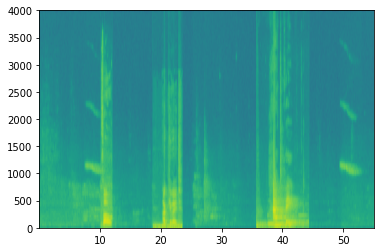

In [27]:
x = graph_spectrogram("/content/drive/MyDrive/Colab Notebooks/TWD/audio_examples/example_train.wav")

In [28]:
_, data = wavfile.read("/content/drive/MyDrive/Colab Notebooks/TWD/audio_examples/example_train.wav")
print("Time steps in audio recording before spectrogram", data[:,0].shape)
print("Time steps in input after spectrogram", x.shape)

Time steps in audio recording before spectrogram (441000,)
Time steps in input after spectrogram (101, 5511)


In [29]:
Tx = 5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

In [30]:
Ty = 1375 # The number of time steps in the output of our model

In [32]:
# Load audio segments using pydub 
activates, negatives, backgrounds = load_raw_audio('/content/drive/MyDrive/Colab Notebooks/TWD/raw_data/')

print("background len should be 10,000, since it is a 10 sec clip\n" + str(len(backgrounds[0])),"\n")
print("activate[0] len may be around 1000, since an `activate` audio clip is usually around 1 second (but varies a lot) \n" + str(len(activates[0])),"\n")
print("activate[1] len: different `activate` clips can have different lengths\n" + str(len(activates[1])),"\n")

background len should be 10,000, since it is a 10 sec clip
10000 

activate[0] len may be around 1000, since an `activate` audio clip is usually around 1 second (but varies a lot) 
721 

activate[1] len: different `activate` clips can have different lengths
731 



## **FUNCTIONS FOR TIMESTAMPS AND ADDING UP**

In [33]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [34]:
def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start, segment_end = segment_time
    
    
    overlap = False
    
    for previous_start, previous_end in previous_segments: 
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True
            break


    return overlap

In [35]:
def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    segment_ms = len(audio_clip)
    
    segment_time = get_random_time_segment(segment_ms)
    
    retry = 5  
    while is_overlapping(segment_time, previous_segments) and retry >= 0:
        segment_time = get_random_time_segment(segment_ms)
        retry = retry - 1

    if not is_overlapping(segment_time, previous_segments):

        previous_segments.append(segment_time)

        new_background = background.overlay(audio_clip, position = segment_time[0])
        print(segment_time)
    else:
        print("Timeouted")
        new_background = background
        segment_time = (10000, 10000)
    
    return new_background, segment_time

In [36]:
def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 following labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    _, Ty = y.shape
    
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    if segment_end_y < Ty:

        for i in range(segment_end_y+1, segment_end_y+51):
            if i < Ty:
                y[0, i] = 1
    
    return y

sanity checks: 0.0 1.0 0.0


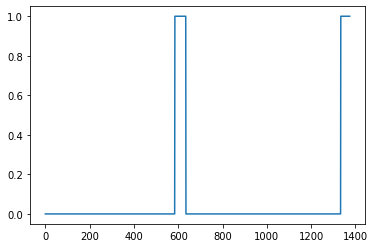

In [37]:
arr1 = insert_ones(np.zeros((1, Ty)), 9700)
plt.plot(insert_ones(arr1, 4251)[0,:])
print("sanity checks:", arr1[0][1333], arr1[0][634], arr1[0][635])

In [47]:
def create_training_example(background, activates, negatives, Ty):
    """
    Creates a training example with a given background, activates, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    activates -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    Ty -- The number of time steps in the output

    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
   
    background = background - 20

    y = np.zeros((1, Ty))

    
    previous_segments = []

    number_of_activates = np.random.randint(0, 5)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]
    
   
    for random_activate in random_activates:
    
        background, segment_time = insert_audio_clip(background, random_activate, previous_segments)
 
        segment_start, segment_end = segment_time
   
        y = insert_ones(y, segment_end)
   
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]


    for random_negative in random_negatives:
        
        background, _ = insert_audio_clip(background, random_negative, previous_segments)

    background = match_target_amplitude(background, -20.0)

    x = graph_spectrogram("/content/drive/MyDrive/Colab Notebooks/TWD/train.wav")
    
    return x, y

## **LOADING AND SAVING DATA**

0
(1567, 2234)
(5771, 6686)
(2671, 4249)
(8486, 8845)
(5461, 5867)
(7590, 8314)
(3579, 4303)
(5500, 5906)
(6751, 7475)
(8612, 9527)
(3407, 4137)
(476, 2054)
(5280, 5934)
(7954, 8674)
(4893, 5492)
(8084, 8999)
(3647, 4301)
(1247, 2825)
(5310, 6034)
(1755, 2663)
(4619, 5339)
(8294, 9209)
(920, 1587)
(2958, 4294)
(8394, 9124)
(1837, 2557)
(5502, 7242)
(1073, 1727)
(3152, 3509)
(1979, 2557)
(8643, 9297)
10
(3197, 3927)
(4326, 6066)
(205, 872)
(8426, 9093)
(6243, 6794)
(8402, 8953)
(4474, 6052)
(8361, 9028)
(686, 1410)
(2735, 3389)
(5365, 5905)
(9369, 9723)
(7240, 7818)
(5043, 6783)
(1948, 3688)
(4242, 4962)
(8262, 8929)
(8973, 9327)
(3559, 4283)
(7027, 7747)
(1432, 2086)
(539, 1193)
(2695, 3419)
(4075, 5815)
(6452, 8030)
(2073, 2672)
(3445, 4044)
(8769, 9677)
(2138, 3716)
20
(8001, 8731)
(4491, 6069)
(2631, 3209)
(3855, 4209)
(1399, 2053)
(9165, 9895)
(5852, 6572)
(490, 844)
(4543, 6934)
(2499, 3219)
(1238, 1816)
(3256, 3613)
(5601, 6516)
(3044, 3768)
(5693, 7433)
(1319, 2897)
(634, 1040)


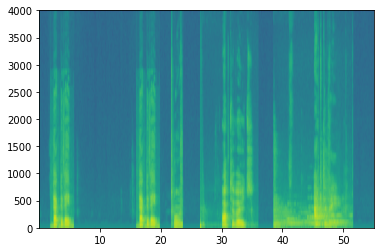

In [48]:
nsamples = 32
X = []
Y = []
for i in range(0, nsamples):
    if i%10 == 0:
        print(i)
    x, y = create_training_example(backgrounds[i % 2], activates, negatives, Ty)
    X.append(x.swapaxes(0,1))
    Y.append(y.swapaxes(0,1))
X = np.array(X)
Y = np.array(Y)
# END SKIP FOR GRADING

In [49]:
IPython.display.Audio("/content/drive/MyDrive/Colab Notebooks/TWD/train.wav")

Output hidden; open in https://colab.research.google.com to view.

In [50]:
IPython.display.Audio("/content/drive/MyDrive/Colab Notebooks/TWD/audio_examples/train_reference.wav")

Output hidden; open in https://colab.research.google.com to view.

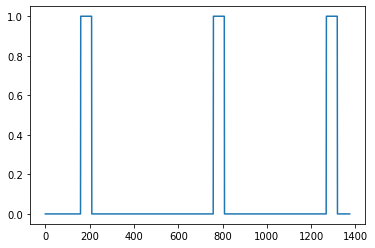

In [52]:
plt.plot(y[0])

In [51]:
# Save the data for further uses
np.save(f'/content/drive/MyDrive/Colab Notebooks/TWD/XY_train/X.npy', X)
np.save(f'/content/drive/MyDrive/Colab Notebooks/TWD/XY_train/Y.npy', Y)
# Load the preprocessed training examples
X = np.load("/content/drive/MyDrive/Colab Notebooks/TWD/XY_train/X.npy")
Y = np.load("/content/drive/MyDrive/Colab Notebooks/TWD/XY_train/Y.npy")

## **DEV SET**

In [54]:
X_dev = np.load("/content/drive/MyDrive/Colab Notebooks/TWD/XY_dev/X_dev.npy")
Y_dev = np.load("/content/drive/MyDrive/Colab Notebooks/TWD/XY_dev/Y_dev.npy")

## **MODEL**

In [55]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from tensorflow.keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam

In [56]:
def modelf(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
   
    X = Conv1D(196, 15, strides=4)(X_input)
   
    X = BatchNormalization()(X)
   
    X = Activation('relu')(X)
  
    X = Dropout(0.8)(X)                                  

    X = GRU(units = 128, return_sequences=True)(X)
   
    X = Dropout(0.8)(X)
   
    X = BatchNormalization()(X)                          
    
    X = GRU(units = 128, return_sequences=True)(X)

    X = Dropout(0.8)(X)       

    X = BatchNormalization()(X)

    X = Dropout(0.8)(X)
    
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X)


    model = Model(inputs = X_input, outputs = X)
    
    return model 

In [57]:
model = modelf(input_shape = (Tx, n_freq))

In [58]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5511, 101)]       0         
                                                                 
 conv1d (Conv1D)             (None, 1375, 196)         297136    
                                                                 
 batch_normalization (BatchN  (None, 1375, 196)        784       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1375, 196)         0         
                                                                 
 dropout (Dropout)           (None, 1375, 196)         0         
                                                                 
 gru (GRU)                   (None, 1375, 128)         125184    
                                                             

## **FITTING MODEL**

In [59]:
from tensorflow.keras.models import model_from_json

json_file = open('/content/drive/MyDrive/Colab Notebooks/TWD/models/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('/content/drive/MyDrive/Colab Notebooks/TWD/models/model.h5')

In [60]:
model.layers[2].trainable = False
model.layers[7].trainable = False
model.layers[10].trainable = False

In [61]:
opt = Adam(lr=1e-6, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [62]:
model.fit(X, Y, batch_size = 16, epochs=1)

2/2 [==============================] - 10s 3s/step - loss: 0.4167 - accuracy: 0.8580


## **TESTING MODEL**

In [63]:
loss, acc, = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

1/1 [==============================] - 2s 2s/step - loss: 0.1884 - accuracy: 0.9238
Dev set accuracy =  0.9237818121910095


## **PREDICTION**

In [67]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)
    
    audio_clip = AudioSegment.from_wav(filename)
    audio_clip = match_target_amplitude(audio_clip, -20.0)
    file_handle = audio_clip.export("/content/drive/MyDrive/Colab Notebooks/TWD/tmp.wav", format="wav")
    filename = "/content/drive/MyDrive/Colab Notebooks/TWD/tmp.wav"

    x = graph_spectrogram(filename)
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

In [68]:
chime_file = "/content/drive/MyDrive/Colab Notebooks/TWD/audio_examples/chime.wav"
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    
    consecutive_timesteps = 0
    
    for i in range(Ty):
        consecutive_timesteps += 1
        
        if consecutive_timesteps > 20:
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds) * 1000)
            consecutive_timesteps = 0
        
        if predictions[0, i, 0] < threshold:
            consecutive_timesteps = 0
        
    audio_clip.export("/content/drive/MyDrive/Colab Notebooks/TWD/chime_output.wav", format='wav')

## **TEST ON DEV**

In [69]:
IPython.display.Audio("/content/drive/MyDrive/Colab Notebooks/TWD/raw_data/dev/1.wav")

Output hidden; open in https://colab.research.google.com to view.

In [70]:
IPython.display.Audio("/content/drive/MyDrive/Colab Notebooks/TWD/raw_data/dev/2.wav")

Output hidden; open in https://colab.research.google.com to view.

In [71]:
filename = "/content/drive/MyDrive/Colab Notebooks/TWD/raw_data/dev/1.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.5)
IPython.display.Audio("/content/drive/MyDrive/Colab Notebooks/TWD/chime_output.wav")

Output hidden; open in https://colab.research.google.com to view.

In [72]:
filename  = "/content/drive/MyDrive/Colab Notebooks/TWD/raw_data/dev/2.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.5)
IPython.display.Audio("/content/drive/MyDrive/Colab Notebooks/TWD/chime_output.wav")

Output hidden; open in https://colab.research.google.com to view.